# Model Selection

In this exercise section, we will see some of the methods to select a model in the first place. These includes:

- backward feature selection, which is a supervised methodology to identify the relevant features for a given task;
- regularization with the $\lambda$ parameter of Lasso;
- Hyperparameter tuning of XGBoost and MLP Neural Network.

In [31]:
import os
import pandas as pd
import numpy as np

In [32]:
np.random.seed(42)

In [33]:
data_path = "data"

In [34]:
# import the clean data from the previous lesson
station_df = pd.read_excel(os.path.join(data_path, "clean_data.xlsx"), index_col=0)

In [35]:
station_df.head()

,Air Temperature (°C),Ammonium (mg/l),Conductivity (µS/cm),DOC (mg/l),Dissolved Oxygen (mg/l),Nitrate (mg/l),Water Temperature (°C),pH,Flow Rate (m³/s),Cumulated Rainfall (mm)
1986-11-30,6.000000,0.330000,569.500000,9.250000,8.700000,0.550000,7.650000,7.7,54.050000,0.813333
1986-12-31,5.794702,0.272517,567.344371,9.034437,9.254305,0.601325,7.865563,7.7,70.463576,3.570968
1987-01-31,5.589404,0.215033,565.188742,8.818874,9.808609,0.652649,8.081126,7.7,86.877152,1.738710
1987-02-28,5.403974,0.163113,563.241722,8.624172,10.309272,0.699007,8.275828,7.7,101.702318,1.289286
1987-03-31,5.198675,0.105629,561.086093,8.408609,10.863576,0.750331,8.491391,7.7,118.115894,0.858065


## Backward Feature Selection

Let us try to identify a convenient subset of $k$ features for our regression task. In principle, we would have to train $\binom{9}{k}$ models, one for each $k \in \{ 1, ..., 9 \}$, and to compare one model against the others. This sounds quite inefficient. Instead, we start from the complete set of features and we try to iteratively remove the least relevant feature. The relevance of a feature can be specified in different ways. For simple models like linear regression, usually the one with the coefficient with the highest p-value is removed. We stop when there are no features with a p-value > 0.5.

In [36]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [37]:
# split the dataframe into features and target
X = station_df.drop(columns=["DOC (mg/l)"]).copy()
y = station_df["DOC (mg/l)"].copy()

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# revert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)

In [38]:
# Let's first train a linear regression model with all the features
X_train_scaled = sm.add_constant(X_train_scaled)

initial_model = sm.OLS(y_train, X_train_scaled).fit()

In [39]:
import numpy as np
import statsmodels.api as sm

def backward_feature_selection(X_bfs, y_bfs):
    features = list(X_bfs.columns)
    best_features = features.copy()
    best_model = None
    best_aic = initial_model.aic

    # while there are features to remove
    while len(features) > 1:
        
        # Initialize the best feature and the current best features
        current_best_features = best_features.copy()

        # for each feature
        for feature in features:
            remaining_features = [f for f in features if f != feature]  # Remove one feature
            X_step = X_bfs[remaining_features]
            X_step = sm.add_constant(X_step)
            model = sm.OLS(y_bfs, X_step).fit()
            aic = model.aic

            # If the AIC of the new model is better, store the new AIC and the new features
            if aic < best_aic:
                best_aic = aic
                # Store the new best features
                best_features = remaining_features
                best_model = model
                removed_feature = feature  # Store the removed feature
            
        # If no feature was removed, stop the loop
        if best_features == current_best_features:
            print("No further improvement in AIC. Stopping.")
            break

        print(f"New best AIC: {best_aic} | Removed feature: {removed_feature}")
        # Update the features to the current best features for the next iteration
        features = best_features.copy()

    return best_features, best_model


In [40]:
selected_features, model = backward_feature_selection(X_train_scaled, y_train)

New best AIC: 1014.7329578311163 | Removed feature: Ammonium (mg/l)
New best AIC: 1013.0302822781418 | Removed feature: Dissolved Oxygen (mg/l)
New best AIC: 1011.7243163875597 | Removed feature: Air Temperature (°C)
No further improvement in AIC. Stopping.


In [41]:
print(f"Selected features: {selected_features}")
print()
print(model.summary())

Selected features: ['const', 'Conductivity (µS/cm)', 'Nitrate (mg/l)', 'Water Temperature (°C)', 'pH', 'Flow Rate (m³/s)', 'Cumulated Rainfall (mm)']

                            OLS Regression Results                            
Dep. Variable:             DOC (mg/l)   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     19.12
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           2.79e-19
Time:                        17:16:54   Log-Likelihood:                -498.86
No. Observations:                 357   AIC:                             1012.
Df Residuals:                     350   BIC:                             1039.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t   

In [9]:
# predict the target for the test set
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

y_pred = model.predict(sm.add_constant(X_test_scaled))

In [10]:
print(model.summary())

print()
print()

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred).round(3))

                            OLS Regression Results                            
Dep. Variable:             DOC (mg/l)   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     12.78
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           1.36e-17
Time:                        14:16:58   Log-Likelihood:                -498.36
No. Observations:                 357   AIC:                             1017.
Df Residuals:                     347   BIC:                             1056.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Let's remove the Ammonium since it is the one with the highest p-value

In [11]:
X_train_scaled.drop(columns=["Ammonium (mg/l)"], inplace=True)
X_test_scaled.drop(columns=["Ammonium (mg/l)"], inplace=True)

In [12]:
# train the model again
model = sm.OLS(y_train, X_train_scaled).fit()

In [13]:
y_pred = model.predict(sm.add_constant(X_test_scaled))

In [14]:
print(model.summary())

print()
print()

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred).round(3))

                            OLS Regression Results                            
Dep. Variable:             DOC (mg/l)   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     14.42
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           3.44e-18
Time:                        14:16:58   Log-Likelihood:                -498.37
No. Observations:                 357   AIC:                             1015.
Df Residuals:                     348   BIC:                             1050.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The $R^2_{\text{adj}}$ slightly increased, while the MSE remained equal.
Let's now remove the Dissolved Oxygen since it is the one with the highest p-value.

In [15]:
X_train_scaled.drop(columns=["Dissolved Oxygen (mg/l)"], inplace=True)
X_test_scaled.drop(columns=["Dissolved Oxygen (mg/l)"], inplace=True)

In [16]:
# train the model again
model = sm.OLS(y_train, X_train_scaled).fit()

In [17]:
y_pred = model.predict(sm.add_constant(X_test_scaled))

In [18]:
print(model.summary())

print()
print()

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred).round(3))

                            OLS Regression Results                            
Dep. Variable:             DOC (mg/l)   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     16.47
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           9.29e-19
Time:                        14:16:58   Log-Likelihood:                -498.52
No. Observations:                 357   AIC:                             1013.
Df Residuals:                     349   BIC:                             1044.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The $R^2_{\text{adj}}$ slightly increased, while the MSE remained equal.
Let's now remove the Air Temperature since it is the one with the highest p-value.

In [19]:
X_train_scaled.drop(columns=["Air Temperature (°C)"], inplace=True)
X_test_scaled.drop(columns=["Air Temperature (°C)"], inplace=True)

In [20]:
# train the model again
model = sm.OLS(y_train, X_train_scaled).fit()

In [21]:
y_pred = model.predict(sm.add_constant(X_test_scaled))

In [22]:
print(model.summary())

print()
print()

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred).round(3))

                            OLS Regression Results                            
Dep. Variable:             DOC (mg/l)   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     19.12
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           2.79e-19
Time:                        14:16:58   Log-Likelihood:                -498.86
No. Observations:                 357   AIC:                             1012.
Df Residuals:                     350   BIC:                             1039.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The $R^2_{\text{adj}}$ slightly increased, while the MSE remained almost equal. No more features have a p-value > 0.5 so we stop. There was not a real improvement in performance, but we managed to achieve slightly better performances with less features, meaning that the ones removes were redundant.

## Regularization

We are going to use Lasso regularization, which is indeed a model selection and feature selection technique, as it adds a $L_1$-norm to the loss function shrinking the coefficients of less important features toward zero. We are going to perform cross validation for a set of values of the regularization term $\lambda$. Note that if $\lambda = 0$, we go back to classic OLS linear regression.

In [23]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [24]:
# split the dataframe into features and target
X = station_df.drop(columns=["DOC (mg/l)"]).copy()
y = station_df["DOC (mg/l)"].copy()

# split the data into training and testing sets
# TODO cambiare in validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# revert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

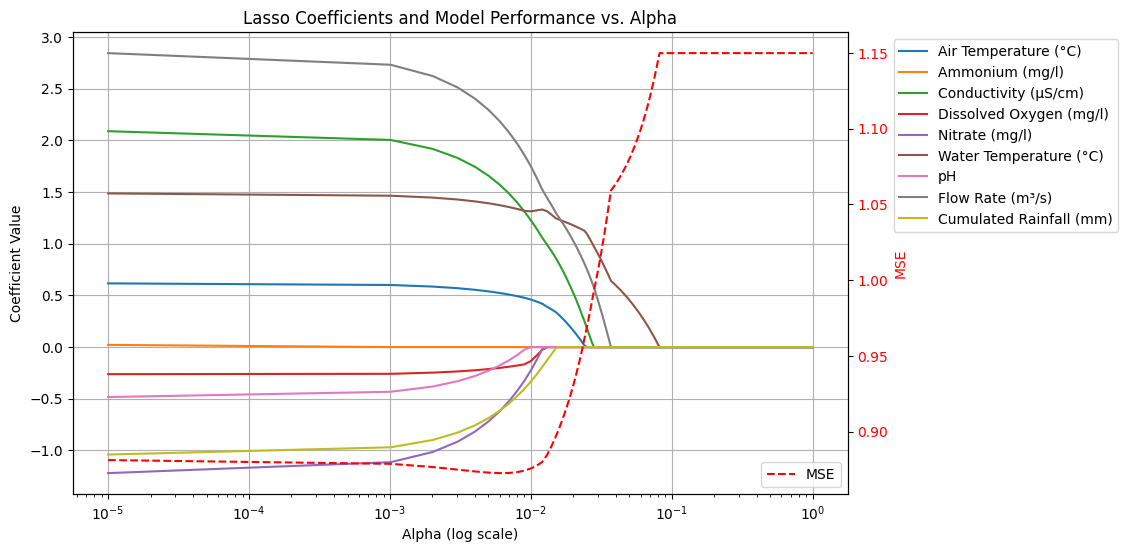

In [25]:
# show how the coefficients change with different lambdas (alphas in sklearn)
# together with the model performance

alphas = np.linspace(1e-5, 1, 1000)
coeffs = []
errors = []

for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    coeffs.append(model.coef_)
    errors.append(mean_squared_error(y_test, model.predict(X_test_scaled)))
    
coeffs = np.array(coeffs)

fig, ax1 = plt.subplots(figsize=(10, 6))

for i in range(coeffs.shape[1]):
    ax1.plot(alphas, coeffs[:, i], label=model.feature_names_in_[i])
    
ax1.set_xscale("log")
ax1.set_xlabel("Alpha (log scale)")
ax1.set_ylabel("Coefficient Value")
ax1.set_title("Lasso Coefficients and Model Performance vs. Alpha")
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.grid(True)
    
ax2 = ax1.twinx()
ax2.plot(alphas, errors, color="red", linestyle="dashed", label="MSE")
ax2.set_ylabel("MSE", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="lower right")
    
plt.show()


We can see that as alpha increases, coefficients shrink to zero, leading to a too much simple model, where only the constant term is left, meaning that we get a constant mse. When alpha is small, many coefficients retain their magnitude. When alpha reaches 10-3, coefficients start to shrink and around alpha = 10-2 a subset of features has a coefficient close to zero, meaning that Lasso is performing feature selection. We can also see that we have a slight decrease of the MSE, meaning that Lasso feature selection is leading to a better representation of the relationship between the target and features variable.

## Hyperparameter Tuning

Hyperparameter tuning is the process of finding the optimal values for a model’s hyperparameters, which are parameters that are not learned directly from the data but rather set before training. These hyperparameters control how the model learns and generalizes.

We are going to see two simple techniques, Grid Search (systematically evaluates predefined hyperparameter values) and Random Search (samples random combinations within a given range), but more sophisticated ones can also be used, such as [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization#:~:text=Bayesian%20optimization%20is%20a%20sequential,expensive%2Dto%2Devaluate%20functions.) or frameworks like [Optuna](https://optuna.readthedocs.io/en/stable/).

The models we are going to tune are MLP Neural Network and XGBoost. We use the scikit-learn package which offers both Grid Search and Random Search. For further information, [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) and [RandomSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).

Hyperparameter tuning is usually performed with cross-validation in order to ensure that the selected hyperparameters generalize well on unseen data.

In [26]:
# import necessary libraries
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [27]:
# split the dataframe into features and target
X = station_df.drop(columns=["DOC (mg/l)"]).copy()
y = station_df["DOC (mg/l)"].copy()

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# revert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

### Neural Network

In [28]:
# we are going to define the hyperparameters to search and their ranges of values
# since there are a lof of hyperparameters, we just define a few of them

# TODO far vedere funzione attivazione

mlp_params = {
    "hidden_layer_sizes": [(20,), (50,) , (20, 20), (50, 50)], # number of neurons in each layer
    "activation": ["relu", "logistic","tanh" ], # activation function
    "solver": ["adam", "sgd"], # optimization algorithm
    "learning_rate": ["constant", "adaptive"], # learning rate schedule
    "batch_size": [16, 32,], # size of minibatches
}

#### Grid Search

In [29]:
estimator = MLPRegressor(max_iter=1000)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=mlp_params,
    cv=5,
    scoring="neg_mean_squared_error", # we want to minimize the MSE
    verbose=3, # change to higher values to see more information
)

In [30]:
# this could take a couple of minutes
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-2.519 total time=   0.3s
[CV 2/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-1.393 total time=   0.4s
[CV 3/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-0.788 total time=   0.3s
[CV 4/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-0.606 total time=   0.3s
[CV 5/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-0.657 total time=   0.3s
[CV 1/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=-2.839 total time=   0.2s
[CV 2/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant

GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000),
             param_grid={'activation': ['relu', 'identity'],
                         'batch_size': [16, 32],
                         'hidden_layer_sizes': [(20,), (50,), (20, 20),
                                                (50, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'sgd']},
             scoring='neg_mean_squared_error', verbose=3)

In [31]:
import pprint

# print the results of the best model found
print("The best parameters are:")
pprint.pprint(grid_search.best_params_)
print()
print(f"The best score is: {-grid_search.best_score_.round(3)}")

The best parameters are:
{'activation': 'identity',
 'batch_size': 16,
 'hidden_layer_sizes': (20, 20),
 'learning_rate': 'constant',
 'solver': 'sgd'}

The best score is: 1.177


#### Random Search

In [32]:
estimator = MLPRegressor(max_iter=1000)

random_search = RandomizedSearchCV(
    n_iter=10,
    estimator=estimator,
    param_distributions=mlp_params,
    cv=5,
    scoring="neg_mean_squared_error", # we want to minimize the MSE
    verbose=3, # change to higher values to see more information
)

In [33]:
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=sgd;, score=-2.662 total time=   0.1s
[CV 2/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=sgd;, score=-1.702 total time=   0.1s
[CV 3/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=sgd;, score=-0.739 total time=   0.1s
[CV 4/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=sgd;, score=-0.646 total time=   0.3s
[CV 5/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=sgd;, score=-0.755 total time=   0.1s
[CV 1/5] END activation=relu, batch_size=32, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd;, score=-3.236 total time=   0.4s
[CV 2/5] END activation=relu, batch_size=32, hidden_layer_sizes=(50, 50), learnin

RandomizedSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000),
                   param_distributions={'activation': ['relu', 'identity'],
                                        'batch_size': [16, 32],
                                        'hidden_layer_sizes': [(20,), (50,),
                                                               (20, 20),
                                                               (50, 50)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam', 'sgd']},
                   scoring='neg_mean_squared_error', verbose=3)

In [34]:
# print the results of the best model found
print("The best parameters are:")
pprint.pprint(random_search.best_params_)
print()
print(f"The best score is: {-random_search.best_score_.round(3)}")

The best parameters are:
{'activation': 'identity',
 'batch_size': 32,
 'hidden_layer_sizes': (50,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

The best score is: 1.235


### XGBoost

In [35]:
# we are going to use tree-based models
xgb_params = {
    "n_estimators": [20, 50, 100], # number of trees
    "eta": [0.01, 0.1, 0.3, 0.5, 0.7], # learning rate
    "max_depth": [3, 5, 7], # maximum depth of the trees\
}

#### Grid Search

In [36]:
estimator = XGBRegressor()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=xgb_params,
    cv=5,
    scoring="neg_mean_squared_error", # we want to minimize the MSE
    verbose=3, # change to higher values to see more information
)

In [37]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-2.698 total time=   0.1s
[CV 2/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-1.917 total time=   0.0s
[CV 3/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-0.581 total time=   0.0s
[CV 4/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-0.727 total time=   0.0s
[CV 5/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-0.968 total time=   0.0s
[CV 1/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-2.684 total time=   0.0s
[CV 2/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-1.868 total time=   0.1s
[CV 3/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-0.564 total time=   0.1s
[CV 4/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-0.672 total time=   0.0s
[CV 5/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-0.922 total time=   0.1s
[CV 1/5] END eta=0.01, max_depth=3, n_estimators=100;, score=-2.649 total time

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'eta': [0.01, 0.1, 0.3, 0.5, 0.7],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [20, 50, 100]},
             scoring='neg_mean_squared_error', verbose=3)

In [38]:
# print the results of the best model found
print("The best parameters are:")
pprint.pprint(grid_search.best_params_)
print()
print(f"The best score is: {-grid_search.best_score_.round(3)}")

The best parameters are:
{'eta': 0.1, 'max_depth': 7, 'n_estimators': 20}

The best score is: 1.288


#### Random Search

In [39]:
random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=xgb_params,
    cv=5,
    scoring="neg_mean_squared_error", # we want to minimize the MSE
    verbose=3, # change to higher values to see more information
)

In [40]:
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END eta=0.5, max_depth=7, n_estimators=20;, score=-3.272 total time=   0.1s
[CV 2/5] END eta=0.5, max_depth=7, n_estimators=20;, score=-1.852 total time=   0.0s
[CV 3/5] END eta=0.5, max_depth=7, n_estimators=20;, score=-1.022 total time=   0.0s
[CV 4/5] END eta=0.5, max_depth=7, n_estimators=20;, score=-0.609 total time=   0.0s
[CV 5/5] END eta=0.5, max_depth=7, n_estimators=20;, score=-0.905 total time=   0.0s
[CV 1/5] END eta=0.01, max_depth=7, n_estimators=50;, score=-2.766 total time=   0.1s
[CV 2/5] END eta=0.01, max_depth=7, n_estimators=50;, score=-1.763 total time=   0.1s
[CV 3/5] END eta=0.01, max_depth=7, n_estimators=50;, score=-0.597 total time=   0.1s
[CV 4/5] END eta=0.01, max_depth=7, n_estimators=50;, score=-0.597 total time=   0.1s
[CV 5/5] END eta=0.01, max_depth=7, n_estimators=50;, score=-0.884 total time=   0.1s
[CV 1/5] END eta=0.7, max_depth=3, n_estimators=50;, score=-3.100 total time=   0.1s

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'eta': [0.01, 0.1, 0.3, 0.5, 0.7],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [20, 50, 100]},
                   scoring='neg_mean_squared_error', verbose=3)

In [41]:
# print the results of the best model found
print("The best parameters are:")
pprint.pprint(random_search.best_params_)
print()
print(f"The best score is: {-random_search.best_score_.round(3)}")

The best parameters are:
{'eta': 0.01, 'max_depth': 3, 'n_estimators': 100}

The best score is: 1.312


We can see that grid search evaluates every possible combination of parameters' values given, while random search just a subset. The trade-off is that with grid search, the combination with the smallest error will be surely found but the computation time will be much higher with respect to random search as it is basically a brute-forcing technique.